# CSC2042S 2025
## Assignment 2 - Perceptron Image Classification
### Maryam Abrahams (ABRMAR043)

In [1]:
# Imports and Setup

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


## Task 1: Data Processing

We start by loading the Simpsons-MNIST dataset from the directory structure and handling it so that we can create train/validation splits and prepare the data for the perceptron model.

We'll do this by creating a function, load, which takes in the parameters (base_path: the path to the main dataset directory, mode: color vs gray, size: target image size ) and which returns a numpy array of converted images (both images and labels), as well as label_map: a dictionary mapping the folder names to numeric labels.



In [2]:
# Loading the dataset 

def load(base_path, mode="grayscale", size = (28, 28)):

    path = os.path.join(base_path, 'dataset', mode, 'train')
    
    characters = ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson',
                 'krusty_the_clown', 'lisa_simpson', 'marge_simpson',
                 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders',
                 'principal_skinner']

    label_map = {char: idx for idx, char in enumerate(characters)}
    images = []
    labels = []

    print(f"Loading {mode} images from: {path}\n")

    for character in characters: 
        char_path = os.path.join(path, character)

        if not os.path.exists(char_path): 
            print(f"Warning: Directory {char_path} does not exist\n")
            continue

        for file in os.listdir(char_path): 
            if file.endswith(".jpg"): 
                img_path = os.path.join(char_path, file)

                try: 
                    with Image.open(img_path) as img: 
                        if mode == "grayscale": 
                            img = img.convert("L") # make grescale
                        else: 
                            img = img.convert("RGB") # make colorful

                        if img.size != size: 
                            img = img.resize(size)

                        img_array = np.array(img)
                        images.append(img_array) 
                        labels.append(label_map[character])
                        
                except Exception as e: 
                    print(f"Error loading {img_path}: {e}\n")

# Converting the images to numpy arrays
    
    X = np.array(images) 
    y = np.array(labels) 

    print(f"Loaded {X.shape[0]} {mode} images with shape {X.shape[1:]}\n")
    return X, y, label_map

In [3]:
# Loading both the gray and colored datasets: 

base_path = r"C:\Users\Yello\OneDrive - University of Cape Town\2025 Second Year\Second Semester\CSC2042S\Assignment 2"

try:
    X_gray, y_gray, label_map = load(base_path, mode='grayscale')
    X_rgb, y_rgb, _ = load(base_path, mode='rgb')
    
    print(f"Grayscale data shape: {X_gray.shape}")
    print(f"RGB data shape: {X_rgb.shape}")
    print(f"Label mapping: {label_map}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check that the dataset path is correct.")

Loading grayscale images from: C:\Users\Yello\OneDrive - University of Cape Town\2025 Second Year\Second Semester\CSC2042S\Assignment 2\dataset\grayscale\train

Loaded 8000 grayscale images with shape (28, 28)

Loading rgb images from: C:\Users\Yello\OneDrive - University of Cape Town\2025 Second Year\Second Semester\CSC2042S\Assignment 2\dataset\rgb\train

Loaded 8000 rgb images with shape (28, 28, 3)

Grayscale data shape: (8000, 28, 28)
RGB data shape: (8000, 28, 28, 3)
Label mapping: {'bart_simpson': 0, 'charles_montgomery_burns': 1, 'homer_simpson': 2, 'krusty_the_clown': 3, 'lisa_simpson': 4, 'marge_simpson': 5, 'milhouse_van_houten': 6, 'moe_szyslak': 7, 'ned_flanders': 8, 'principal_skinner': 9}


Next I'll create a function, splits, to create training and validation splits from the loaded data so that the stratified data is better understood. And in preparation for the perceptron implementation I'll normalize the data, creating multiple normalization options for better hyperparameter tuning later on. 

In [4]:
# Training and validation splits

def splits(X, y, test_size = 0.2, random_state = 42, flatten = True): 

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state = random_state, stratify = y)

    if flatten: 
        if len(X_train.shape) > 2: 
            X_train = X_train.reshape(X_train.shape[0], -1) 
            X_val = X_val.reshape(X_val.shape[0], -1) 

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
    return X_train, X_val, y_train, y_val
    
X_gray_train, X_gray_val, y_gray_train, y_gray_val = splits(X_gray, y_gray)
X_rgb_train, X_rgb_val, y_rgb_train, y_rgb_val = splits(X_rgb, y_rgb)
    

Training set: (6400, 784), Validation set: (1600, 784)
Training set: (6400, 2352), Validation set: (1600, 2352)


In [5]:
# Normalization options

def normalize(X_train, X_val, method = "none"): 

    if method == "minmax": # to [0, 1]
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        
    elif method == 'zscore':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.astype('float32'))
        X_val = scaler.transform(X_val.astype('float32'))
        
    elif method == 'none':
        X_train = X_train.astype('float32')
        X_val = X_val.astype('float32')
    
    return X_train, X_val

X_gray_train_norm, X_gray_val_norm = normalize(X_gray_train, X_gray_val, 'minmax')
print(f"Normalized grayscale - Train range: [{X_gray_train_norm.min():.3f}, {X_gray_train_norm.max():.2f}]")


Normalized grayscale - Train range: [0.000, 1.00]


## Task 2: Multi-class Perceptron Implementation

For our multi-class perceptron implementation, we  create both a binary perceptron and a multiclass perceptron class using the outline provided to us in the tutorials. For the multiclass implementation, it should be from scratch using a one-vs-rest approach, and for the binary version, we should implement the perceptron learning rule, plus a predict function to return a binary label, selecting the class with the highest score.

In [6]:
# Binary perceptron class

class BinaryPerceptron:

    def __init__(self, n_features,learning_rate = 0.1, random_state = None):
        self.weights = np.ones(n_features, dtype=float)
        self.bias = 0.0
        self.lr = learning_rate
        self.errors = []
        self.random_state = random_state

    def predict(self, x):
        x = np.array(x, dtype=float)
        net_input = np.dot(x, self.weights) + self.bias
        return 1 if net_input >= 0 else 0

    def apply_learning_rule(self, x, y):
        y_hat = self.predict(x)
        error = y - y_hat
        self.weights += self.lr * error * x
        self.bias += self.lr * error
        return abs(error)

    def fit(self, X, y, max_epochs = 1000): 
        self.errors = []

        for epoch in range(max_epochs):
            total_error = 0
            
            for i in range(len(X)):
                error = self.apply_learning_rule(X[i], y[i])
                total_error += error
            
            self.errors.append(total_error)
            if total_error == 0:
                print(f"Converged after {epoch + 1} epochs")
                break
        
        return self
        
    def __repr__(self):
        return f"BinaryPerceptron(weights={self.weights}, bias={self.bias:.3f}, learning rate={self.lr})\n"

In [7]:
# Multiclass perceptron

class MulticlassPerceptron:

    def __init__(self, n_features, n_classes =10, learning_rate =0.1, random_state = 42):
        self.n_classes = n_classes
        self.perceptrons = [
            BinaryPerceptron(n_features, learning_rate, random_state + i) 
            for i in range(n_classes)
        ]

    def fit(self, X, y, max_epochs=1000):
        for i in range(self.n_classes):
            print(f"Training perceptron for class {i}...")
            y_binary = np.where(y == i, 1, 0)
            self.perceptrons[i].fit(X, y_binary, max_epochs)
        return self
    
    def predict(self, X):
        scores = np.zeros((len(X), self.n_classes))
        for i, perceptron in enumerate(self.perceptrons):
            scores[:, i] = np.dot(X, perceptron.weights) + perceptron.bias
        return np.argmax(scores, axis=1)
        

## Task 3: Training 

We seek to implement a training loop to find optimal weights and learning rules (the hyperparameters). We also wish to investigate multiple stopping criteria, including fixed epochs, error thresholds, and early stopping.

In [8]:
# Training loop

class EnhancedBinaryPerceptron(BinaryPerceptron): 

    def __init__(self, n_features, learning_rate=0.1, random_state=None): 
        super().__init__(n_features, learning_rate, random_state)
        self.val_accuracies = []

    def fit(self, X, y, X_val=None, y_val =None, max_epochs = 1000, error_threshold=0.0, patience=5, verbose=True): 
        self.errors = []
        self.val_accuracies = []

        # Collecting for early stopping: 
        best_weights = self.weights.copy()
        best_bias = self.bias
        best_val_acc = 0 
        patience_counter = 0

        for epoch in range(max_epochs):

            indices = np.random.permutation(len(X))
            X_shuffled, y_shuffled = X[indices], y[indices]
            
            total_error = 0
            for i in range(len(X)):
                error = self.apply_learning_rule(X_shuffled[i], y_shuffled[i])
                total_error += error
            self.errors.append(total_error)

            if X_val is not None and y_val is not None: 
                val_acc = self.accuracy(X_val, y_val)
                self.val_accuracies.append(val_acc)
                
                # Early stop logic: 
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                    patience_counter = 0
                else: 
                    patience_counter += 1
                if patience_counter >= patience: 
                    if verbose: 
                        print(f"Early stopping at epoch {epoch+1}, best accuracy value: {best_val_acc:.4f}")
                        self.weights = best_weights
                        self.bias = best_bias
                        break
                    
            if total_error <= error_threshold:
                if verbose: 
                    print(f"Converged after {epoch + 1} epochs")
                break
            if verbose and (epoch + 1) % 100 == 0: 
                print(f"Epoch {epoch+1}, Training error: {total_error}")
                
        if verbose and epoch == max_epochs - 1: 
            print(f"Reached maximum epochs ({max_epochs})")
                
        return self

    def accuracy(self, X, y): 
        predictions = np.array([self.predict(x) for x in X])
        return np.mean(predictions == y)

    def predict_score(self, x): 
        return np.dot(x, self.weights) + self.bias


In [9]:
# Investigating stop conditions

class_names = {
    0: 'Bart Simpson',
    1: 'Charles Montgomery Burns', 
    2: 'Homer Simpson',
    3: 'Krusty the Clown',
    4: 'Lisa Simpson',
    5: 'Marge Simpson',
    6: 'Milhouse Van Houten',
    7: 'Moe Szyslak',
    8: 'Ned Flanders',
    9: 'Principal Skinner' 
}

# Testing the stopping criteria for one class only, 0: Bart Simpson

class_index = 0
y_binary_train = np.where(y_gray_train == class_index, 1, 0)
y_binary_val = np.where(y_gray_val == class_index, 1, 0)

strategies = [
    {'name': 'Fixed Epochs (1000)', 'max_epochs': 500, 'error_threshold': -1, 'patience': 1000},
    {'name': 'Error Threshold (0 errors)', 'max_epochs': 1000, 'error_threshold': 0, 'patience': 1000},
    {'name': 'Early Stopping (patience=10)', 'max_epochs': 500, 'error_threshold': -1, 'patience': 10}
]

results = []

print("Testing the stop criteria strategies for the Bart Simpson class: ")

for strategy in strategies: 
    print(f"\n=== Testing: {strategy['name']} ===")
    
    perceptron = EnhancedBinaryPerceptron( n_features=X_gray_train_norm.shape[1], learning_rate=0.1, random_state=42 )
    
    perceptron.fit( X_gray_train_norm, y_binary_train, X_val=X_gray_val_norm, y_val=y_binary_val, max_epochs=strategy['max_epochs'], error_threshold=strategy['error_threshold'], patience=strategy['patience'], verbose=True )

    results.append({
    'strategy': strategy['name'],
    'epochs': len(perceptron.errors),
    'final_error': perceptron.errors[-1],
    'final_accuracy': perceptron.accuracy(X_gray_val_norm, y_binary_val)
    })

# Comparing and Analyzing results
comparison_df = pd.DataFrame(results)
print("\n=== Comparison of Stopping Criteria ===")
print(comparison_df)

Testing the stop criteria strategies for the Bart Simpson class: 

=== Testing: Fixed Epochs (1000) ===
Epoch 100, Training error: 914
Epoch 200, Training error: 906
Epoch 300, Training error: 918
Epoch 400, Training error: 873
Epoch 500, Training error: 901
Reached maximum epochs (500)

=== Testing: Error Threshold (0 errors) ===
Epoch 100, Training error: 911
Epoch 200, Training error: 936
Epoch 300, Training error: 902
Epoch 400, Training error: 925
Epoch 500, Training error: 897
Epoch 600, Training error: 892
Epoch 700, Training error: 921
Epoch 800, Training error: 915
Epoch 900, Training error: 890
Epoch 1000, Training error: 907
Reached maximum epochs (1000)

=== Testing: Early Stopping (patience=10) ===
Early stopping at epoch 11, best accuracy value: 0.8988

=== Comparison of Stopping Criteria ===
                       strategy  epochs  final_error  final_accuracy
0           Fixed Epochs (1000)     500          901        0.883750
1    Error Threshold (0 errors)    1000     

## Task 4: Hyperparameter tuning 

We want systematically search and compare combinations of learning rate, weight initialization and  normalization methods for both gray and color images to find the optimal performance.

In [10]:
# Tunable perceptron modelling 

class TunableBinaryPerceptron: 
    
    def __init__(self, n_features, learning_rate=0.1, init_strategy='ones', random_state=None):
        # Initialize weights based on strategy
        if random_state:
            np.random.seed(random_state)
        
        if init_strategy == 'zero':
            self.weights = np.zeros(n_features, dtype=float)
        elif init_strategy == 'constant':
            self.weights = np.ones(n_features, dtype=float) * 0.01
        elif init_strategy == 'uniform':
            self.weights = np.random.uniform(-0.01, 0.01, n_features)
        elif init_strategy == 'gaussian':
            self.weights = np.random.normal(0, 0.01, n_features)
        else:  # 'ones' - same as your original
            self.weights = np.ones(n_features, dtype=float)
        
        self.bias = 0.0
        self.lr = learning_rate
        self.errors = []
        self.random_state = random_state
    
    def predict(self, x):
        x = np.array(x, dtype=float)
        net_input = np.dot(x, self.weights) + self.bias
        return 1 if net_input >= 0 else 0
    
    def apply_learning_rule(self, x, y):
        y_hat = self.predict(x)
        error = y - y_hat
        self.weights += self.lr * error * x
        self.bias += self.lr * error
        return abs(error)
    
    def fit(self, X, y, max_epochs=1000): 
        self.errors = []
        for epoch in range(max_epochs):
            total_error = 0
            
            for i in range(len(X)):
                error = self.apply_learning_rule(X[i], y[i])
                total_error += error
            
            self.errors.append(total_error)
            if total_error == 0:
                break
        
        return self

#_________________________________________________________________________________________________________

class TunableMulticlassPerceptron: 
    
    def __init__(self, n_features, n_classes=10, learning_rate=0.1, init_strategy='ones', random_state=42):
        self.n_classes = n_classes
        self.perceptrons = [
            TunableBinaryPerceptron(n_features, learning_rate, init_strategy, random_state + i) 
            for i in range(n_classes)
        ]
    
    def fit(self, X, y, max_epochs=1000, verbose=False):
        for i in range(self.n_classes):
            if verbose:
                print(f"Training perceptron for class {i}...")
            y_binary = np.where(y == i, 1, 0)
            self.perceptrons[i].fit(X, y_binary, max_epochs)
        return self
    
    def predict(self, X):
        scores = np.zeros((len(X), self.n_classes))
        for i, perceptron in enumerate(self.perceptrons):
            scores[:, i] = np.dot(X, perceptron.weights) + perceptron.bias
        return np.argmax(scores, axis=1)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
        

In [11]:

def tune_multiclass_perceptron(X_train, y_train, X_val, y_val, modality_name):
    tuning_results = []
    
    # Testing most combos
    for lr in [ 0.01, 0.5]:
        for init_strat in ['zero', 'uniform', 'gaussian']:
            for norm_method in ['none', 'minmax', 'zscore']:
                
                X_train_norm, X_val_norm = normalize(X_train, X_val, norm_method)

                model = TunableMulticlassPerceptron(
                    n_features=X_train_norm.shape[1],
                    n_classes=10,
                    learning_rate=lr,
                    init_strategy=init_strat,
                    random_state=42
                )
                
                model.fit(X_train_norm, y_train, max_epochs=25, verbose=False)
                val_accuracy = model.accuracy(X_val_norm, y_val)
                
                tuning_results.append({
                    'learning_rate': lr,
                    'init_strategy': init_strat,
                    'normalization': norm_method,
                    'accuracy': val_accuracy
                })
                
                print(f"LR: {lr}, Init: {init_strat}, Norm: {norm_method} -> Acc: {val_accuracy:.4f}")
    return pd.DataFrame(tuning_results)


# Tuning grey multisclass perceptron: 

print("=== TUNING GRAYSCALE MULTICLASS PERCEPTRON ===")
gray_results = tune_multiclass_perceptron(
    X_gray_train, y_gray_train, 
    X_gray_val, y_gray_val,
    "Grayscale"
)

best_gray = gray_results.loc[gray_results['accuracy'].idxmax()]
print(f"\nBest Grayscale: LR={best_gray['learning_rate']}, Init={best_gray['init_strategy']}, Norm={best_gray['normalization']}, Acc={best_gray['accuracy']:.4f}")

# Tuning RGB multiclass perceptron

X_rgb_train_flat = X_rgb_train.reshape(X_rgb_train.shape[0], -1)
X_rgb_val_flat = X_rgb_val.reshape(X_rgb_val.shape[0], -1)

print("\n=== TUNING RGB MULTICLASS PERCEPTRON ===")
rgb_results = tune_multiclass_perceptron(
    X_rgb_train_flat, y_rgb_train,
    X_rgb_val_flat, y_rgb_val, 
    "RGB"
)

best_rgb = rgb_results.loc[rgb_results['accuracy'].idxmax()]
print(f"\nBest RGB: LR={best_rgb['learning_rate']}, Init={best_rgb['init_strategy']}, Norm={best_rgb['normalization']}, Acc={best_rgb['accuracy']:.4f}")

=== TUNING GRAYSCALE MULTICLASS PERCEPTRON ===
LR: 0.01, Init: zero, Norm: none -> Acc: 0.2056
LR: 0.01, Init: zero, Norm: minmax -> Acc: 0.2137
LR: 0.01, Init: zero, Norm: zscore -> Acc: 0.2106
LR: 0.01, Init: uniform, Norm: none -> Acc: 0.2075
LR: 0.01, Init: uniform, Norm: minmax -> Acc: 0.1994
LR: 0.01, Init: uniform, Norm: zscore -> Acc: 0.2013
LR: 0.01, Init: gaussian, Norm: none -> Acc: 0.2044
LR: 0.01, Init: gaussian, Norm: minmax -> Acc: 0.1994
LR: 0.01, Init: gaussian, Norm: zscore -> Acc: 0.2119
LR: 0.5, Init: zero, Norm: none -> Acc: 0.2056
LR: 0.5, Init: zero, Norm: minmax -> Acc: 0.2137
LR: 0.5, Init: zero, Norm: zscore -> Acc: 0.2106
LR: 0.5, Init: uniform, Norm: none -> Acc: 0.2156
LR: 0.5, Init: uniform, Norm: minmax -> Acc: 0.2156
LR: 0.5, Init: uniform, Norm: zscore -> Acc: 0.2050
LR: 0.5, Init: gaussian, Norm: none -> Acc: 0.2175
LR: 0.5, Init: gaussian, Norm: minmax -> Acc: 0.2044
LR: 0.5, Init: gaussian, Norm: zscore -> Acc: 0.2081

Best Grayscale: LR=0.5, Init=ga

In [12]:
# Analysis

print("="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)

print(f"GRAYSCALE BEST: LR={best_gray['learning_rate']}, Init={best_gray['init_strategy']}, Norm={best_gray['normalization']} with Acc={best_gray['accuracy']:.4f}")
print(f"RGB BEST:       LR={best_rgb['learning_rate']}, Init={best_rgb['init_strategy']}, Norm={best_rgb['normalization']} with Acc={best_rgb['accuracy']:.4f}")

print("\nBEST LEARNING RATE:")
print(f"Gray: {best_gray['learning_rate']}, RGB: {best_rgb['learning_rate']}")

print("\nBEST INITIALIZATION:")
print(f"Gray: {best_gray['init_strategy']}, RGB: {best_rgb['init_strategy']}")

print("\nBEST NORMALIZATION:")
print(f"Gray: {best_gray['normalization']}, RGB: {best_rgb['normalization']}")

print("\nACCURACY COMPARISON:")
print(f"Grayscale: {best_gray['accuracy']:.4f}, RGB: {best_rgb['accuracy']:.4f}")
print(f"Difference: {abs(best_gray['accuracy'] - best_rgb['accuracy']):.4f} ({'Grayscale' if best_gray['accuracy'] > best_rgb['accuracy'] else 'RGB'} better)")

HYPERPARAMETER TUNING RESULTS
GRAYSCALE BEST: LR=0.5, Init=gaussian, Norm=none with Acc=0.2175
RGB BEST:       LR=0.5, Init=gaussian, Norm=none with Acc=0.4094

BEST LEARNING RATE:
Gray: 0.5, RGB: 0.5

BEST INITIALIZATION:
Gray: gaussian, RGB: gaussian

BEST NORMALIZATION:
Gray: none, RGB: none

ACCURACY COMPARISON:
Grayscale: 0.2175, RGB: 0.4094
Difference: 0.1919 (RGB better)


## Task 5: Evaluation

By training the final models with the best hyperparamters, we want to evaluate on our test and validation sets the evaluation metrics: accuracy, precision, recall and the F1-score and generate confusion matrices per class.

In [13]:
# Loading the test data only 

def load_test_data(base_path, mode="grayscale", size=(28, 28)):
    
    test_path = base_path.replace('train', 'test') if 'train' in base_path else base_path
    path = os.path.join(base_path, 'dataset', mode, 'test') 
    
    characters = ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson',
                 'krusty_the_clown', 'lisa_simpson', 'marge_simpson',
                 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders',
                 'principal_skinner']

    label_map = {char: idx for idx, char in enumerate(characters)}
    images = []
    labels = []

    print(f"Loading {mode} test images from: {path}")
    
    for character in characters: 
        char_path = os.path.join(path, character)
        if not os.path.exists(char_path): 
            continue
        for file in os.listdir(char_path): 
            if file.endswith(".jpg"): 
                img_path = os.path.join(char_path, file)
                try: 
                    with Image.open(img_path) as img: 
                        if mode == "grayscale": 
                            img = img.convert("L")
                        else: 
                            img = img.convert("RGB")
                        if img.size != size: 
                            img = img.resize(size)
                        img_array = np.array(img)
                        images.append(img_array) 
                        labels.append(label_map[character])
                except Exception as e: 
                    print(f"Error loading {img_path}: {e}")

    X = np.array(images) 
    y = np.array(labels) 
    print(f"Loaded {X.shape[0]} {mode} test images")
    return X, y

X_gray_test, y_gray_test = load_test_data(base_path, mode='grayscale')
X_rgb_test, y_rgb_test = load_test_data(base_path, mode='rgb')


Loading grayscale test images from: C:\Users\Yello\OneDrive - University of Cape Town\2025 Second Year\Second Semester\CSC2042S\Assignment 2\dataset\grayscale\test
Loaded 2000 grayscale test images
Loading rgb test images from: C:\Users\Yello\OneDrive - University of Cape Town\2025 Second Year\Second Semester\CSC2042S\Assignment 2\dataset\rgb\test
Loaded 2000 rgb test images


In [14]:
# Training data with optimal hyperparameters

print("Training final grayscale model...")
X_gray_train_final, X_gray_val_final = normalize(X_gray_train, X_gray_val, best_gray['normalization'])
final_gray_model = TunableMulticlassPerceptron(
    n_features=X_gray_train_final.shape[1],
    learning_rate=best_gray['learning_rate'], 
    init_strategy=best_gray['init_strategy']
)
final_gray_model.fit(X_gray_train_final, y_gray_train, max_epochs=100)

print("Training final RGB model...")
X_rgb_train_flat = X_rgb_train.reshape(X_rgb_train.shape[0], -1)
X_rgb_val_flat = X_rgb_val.reshape(X_rgb_val.shape[0], -1)
X_rgb_train_final, X_rgb_val_final = normalize(X_rgb_train_flat, X_rgb_val_flat, best_rgb['normalization'])
final_rgb_model = TunableMulticlassPerceptron(
    n_features=X_rgb_train_final.shape[1],
    learning_rate=best_rgb['learning_rate'],
    init_strategy=best_rgb['init_strategy']
)
final_rgb_model.fit(X_rgb_train_final, y_rgb_train, max_epochs=100)

# Preparing data & getting predictions

X_gray_test_flat = X_gray_test.reshape(X_gray_test.shape[0], -1)
X_rgb_test_flat = X_rgb_test.reshape(X_rgb_test.shape[0], -1)
_, X_gray_test_norm = normalize(X_gray_test_flat, X_gray_test_flat, best_gray['normalization'])
_, X_rgb_test_norm = normalize(X_rgb_test_flat, X_rgb_test_flat, best_rgb['normalization'])

gray_val_pred = final_gray_model.predict(X_gray_val_final)
gray_test_pred = final_gray_model.predict(X_gray_test_norm)
rgb_val_pred = final_rgb_model.predict(X_rgb_val_final) 
rgb_test_pred = final_rgb_model.predict(X_rgb_test_norm)

Training final grayscale model...
Training final RGB model...



Grayscale Validation Results:
Accuracy:  0.2056
Precision: 0.2780
Recall:    0.2056
F1-Score:  0.1754

Grayscale Test Results:
Accuracy:  0.1850
Precision: 0.2235
Recall:    0.1850
F1-Score:  0.1563

RGB Validation Results:
Accuracy:  0.3406
Precision: 0.4525
Recall:    0.3406
F1-Score:  0.3351

RGB Test Results:
Accuracy:  0.3325
Precision: 0.4272
Recall:    0.3325
F1-Score:  0.3264

PER-CLASS ANALYSIS

Grayscale Test Per-Class:
              precision    recall  f1-score   support

        Bart       0.14      0.53      0.22       200
       Burns       0.35      0.03      0.06       200
       Homer       0.19      0.23      0.21       200
      Krusty       0.21      0.10      0.14       200
        Lisa       0.13      0.01      0.03       200
       Marge       0.24      0.34      0.28       200
    Milhouse       0.28      0.12      0.16       200
         Moe       0.17      0.30      0.22       200
         Ned       0.25      0.03      0.05       200
     Skinner       0.27 

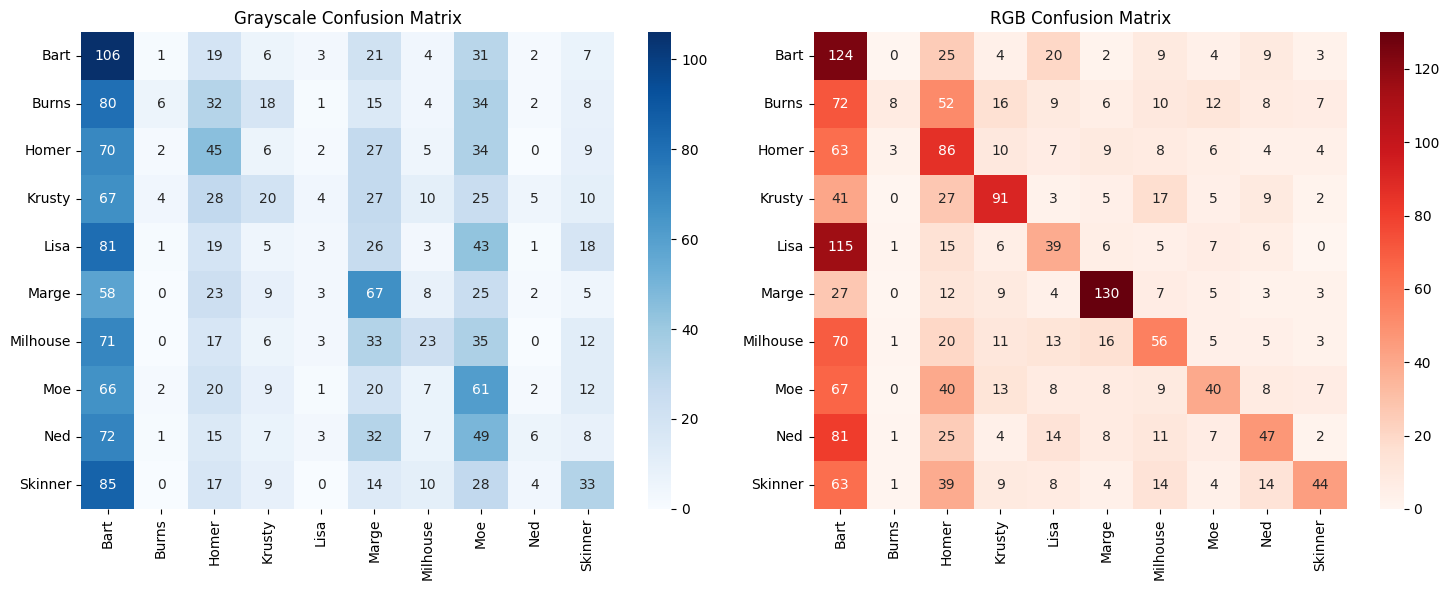


FINAL COMPARISON
Grayscale Test Accuracy: 0.1850
RGB Test Accuracy:       0.3325
RGB performs better by 0.1475



In [15]:

# Reporting all metrics

def report_metrics(y_true, y_pred, name):
    print(f"\n{name} Results:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")

report_metrics(y_gray_val, gray_val_pred, "Grayscale Validation")
report_metrics(y_gray_test, gray_test_pred, "Grayscale Test") 
report_metrics(y_rgb_val, rgb_val_pred, "RGB Validation")
report_metrics(y_rgb_test, rgb_test_pred, "RGB Test")

# Per-class analysis
character_names = ['Bart', 'Burns', 'Homer', 'Krusty', 'Lisa', 'Marge', 'Milhouse', 'Moe', 'Ned', 'Skinner']
print("\n" + "="*50)
print("PER-CLASS ANALYSIS")
print("="*50)
print("\nGrayscale Test Per-Class:")
print(classification_report(y_gray_test, gray_test_pred, target_names=character_names))
print("\nRGB Test Per-Class:")
print(classification_report(y_rgb_test, rgb_test_pred, target_names=character_names))

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
cm_gray = confusion_matrix(y_gray_test, gray_test_pred)
sns.heatmap(cm_gray, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=character_names, yticklabels=character_names)
ax1.set_title('Grayscale Confusion Matrix')
cm_rgb = confusion_matrix(y_rgb_test, rgb_test_pred) 
sns.heatmap(cm_rgb, annot=True, fmt='d', cmap='Reds', ax=ax2, xticklabels=character_names, yticklabels=character_names)
ax2.set_title('RGB Confusion Matrix')
plt.tight_layout()
plt.show()

# Results

print(f"\n" + "="*30)
print("FINAL COMPARISON")
print("="*30)
print(f"Grayscale Test Accuracy: {accuracy_score(y_gray_test, gray_test_pred):.4f}")
print(f"RGB Test Accuracy:       {accuracy_score(y_rgb_test, rgb_test_pred):.4f}")
print(f"RGB performs {'better' if accuracy_score(y_rgb_test, rgb_test_pred) > accuracy_score(y_gray_test, gray_test_pred) else 'worse'} by {abs(accuracy_score(y_rgb_test, rgb_test_pred) - accuracy_score(y_gray_test, gray_test_pred)):.4f}")
print()

## Task 6: RGB vs grayscale analysis

Comparing the performance of the RGB and grayscale models overall and per-character to identify which characters benefit most and least from color information and to find the classification challenges within our dataset analysis.S

In [16]:
# Overall Accuracy Comparisons

print("=" * 50)
print("TASK 6: RGB vs GRAYSCALE ANALYSIS")
print("=" * 50)

gray_accuracy = accuracy_score(y_gray_test, gray_test_pred)
rgb_accuracy = accuracy_score(y_rgb_test, rgb_test_pred)

print(f"\nOverall Performance:")
print(f"Grayscale Accuracy: {gray_accuracy:.4f}")
print(f"RGB Accuracy:       {rgb_accuracy:.4f}")
print(f"RGB Advantage:      {rgb_accuracy - gray_accuracy:.4f}")

if rgb_accuracy > gray_accuracy:
    print(f"RGB performs {rgb_accuracy - gray_accuracy:.4f} better than grayscale")
else:
    print(f"Grayscale performs {gray_accuracy - rgb_accuracy:.4f} better than RGB")

print("-" * 50)


TASK 6: RGB vs GRAYSCALE ANALYSIS

Overall Performance:
Grayscale Accuracy: 0.1850
RGB Accuracy:       0.3325
RGB Advantage:      0.1475
RGB performs 0.1475 better than grayscale
--------------------------------------------------


In [17]:
# Per-class behaviour analysis

print(f"\nPer-character analysis:")
print("-" * 50)

character_names = ['Bart', 'Burns', 'Homer', 'Krusty', 'Lisa', 'Marge', 'Milhouse', 'Moe', 'Ned', 'Skinner']

improvements = []
for i, char in enumerate(character_names):
    # Get F1 scores for each class
    gray_f1 = f1_score(y_gray_test, gray_test_pred, labels=[i], average=None)[0]
    rgb_f1 = f1_score(y_rgb_test, rgb_test_pred, labels=[i], average=None)[0]
    
    improvement = rgb_f1 - gray_f1
    improvements.append((char, improvement, gray_f1, rgb_f1))
    
    print(f"{char:10}: Gray={gray_f1:.3f}, RGB={rgb_f1:.3f}, Diff={improvement:+.3f}")

print("-" * 50)

improvements.sort(key=lambda x: x[1], reverse=True)

print(f"\nCharacters that benefit most:")
print("-" * 50)
for char, improvement, gray_f1, rgb_f1 in improvements[:3]:
    print(f"1. {char}: {improvement:+.3f} improvement (Gray: {gray_f1:.3f} → RGB: {rgb_f1:.3f})")

print(f"\nCharacters that benefit least:")
print("-" * 50)
for char, improvement, gray_f1, rgb_f1 in improvements[-3:]:
    print(f"1. {char}: {improvement:+.3f} change (Gray: {gray_f1:.3f} → RGB: {rgb_f1:.3f})")

print(f"\nMost Challenging characters:")
print("-" * 50)
gray_scores = [(char, gray_f1) for char, _, gray_f1, _ in improvements]
rgb_scores = [(char, rgb_f1) for char, _, _, rgb_f1 in improvements]

gray_scores.sort(key=lambda x: x[1])
rgb_scores.sort(key=lambda x: x[1])

print("Most challenging in Grayscale:")
for char, score in gray_scores[:3]:
    print(f"  {char}: {score:.3f}")

print("Most challenging in RGB:")  
for char, score in rgb_scores[:3]:
    print(f"  {char}: {score:.3f}")

print("-" * 50)
print()



Per-character analysis:
--------------------------------------------------
Bart      : Gray=0.222, RGB=0.269, Diff=+0.047
Burns     : Gray=0.055, RGB=0.074, Diff=+0.019
Homer     : Gray=0.207, RGB=0.318, Diff=+0.111
Krusty    : Gray=0.136, RGB=0.488, Diff=+0.352
Lisa      : Gray=0.027, RGB=0.240, Diff=+0.213
Marge     : Gray=0.278, RGB=0.660, Diff=+0.382
Milhouse  : Gray=0.164, RGB=0.324, Diff=+0.160
Moe       : Gray=0.216, RGB=0.271, Diff=+0.055
Ned       : Gray=0.054, RGB=0.300, Diff=+0.247
Skinner   : Gray=0.205, RGB=0.320, Diff=+0.115
--------------------------------------------------

Characters that benefit most:
--------------------------------------------------
1. Marge: +0.382 improvement (Gray: 0.278 → RGB: 0.660)
1. Krusty: +0.352 improvement (Gray: 0.136 → RGB: 0.488)
1. Ned: +0.247 improvement (Gray: 0.054 → RGB: 0.300)

Characters that benefit least:
--------------------------------------------------
1. Moe: +0.055 change (Gray: 0.216 → RGB: 0.271)
1. Bart: +0.047 change

In [18]:
# Summary

print(f"\nSummary:")
rgb_better_count = sum(1 for _, improvement, _, _ in improvements if improvement > 0)
print(f"• RGB performs better for {rgb_better_count}/10 characters")
print(f"• Grayscale performs better for {10 - rgb_better_count}/10 characters")

if rgb_accuracy > gray_accuracy + 0.05:  # 5% threshold
    print("• RGB provides a clear advantage overall")
elif gray_accuracy > rgb_accuracy + 0.05:
    print("• Grayscale is surprisingly competitive")
else:
    print("• Performance difference is marginal")

# Color benefit analysis
color_beneficial = [char for char, improvement, _, _ in improvements if improvement > 0.05]
if color_beneficial:
    print(f"• Characters that clearly benefit from color: {', '.join(color_beneficial)}")
else:
    print("• No characters show strong color dependency")
    


Summary:
• RGB performs better for 10/10 characters
• Grayscale performs better for 0/10 characters
• RGB provides a clear advantage overall
• Characters that clearly benefit from color: Marge, Krusty, Ned, Lisa, Milhouse, Skinner, Homer, Moe
